<a href="https://colab.research.google.com/github/silasabs/CoherentOptics/blob/main/Jupyter/Carrier%20Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

# Recuperação de Portadora

Este notebook contém algumas implementações dos principais algoritmos que realizam a recuperação de portadora em receptores ópticos digitais coerentes, com a finalidade de compensar o deslocamento de frequência da portadora e o ruído de fase.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, pnorm
from optic.models.devices import pdmCoherentReceiver, basicLaserModel
from optic.models.channels import linearFiberChannel, awgn
from optic.models.tx import simpleWDMTx
from optic.utils import parameters
from optic.comm.metrics import fastBERcalc
from optic.comm.modulation import grayMapping
from optic.plot import pconst

import scipy.constants as const

## 6.1 Frequency Recovery

Existem dois efeitos de fase principais que afetam os sistemas ópticos coerentes digitais. O primeiro é um deslocamento de frequência da portadora, o segundo é o ruído de fase.

Assumindo uma detecção coerente intradina, os lasers transmissores e osciladores locais não operam exatamente na mesma frequência, mas exibem um deslocamento que pode atingir a ordem de alguns gigahertz. Após o front-end óptico, esse deslocamento de frequência é traduzido para o domínio elétrico, levando a uma perda completa da referência de fase para o processo de decisão.

Assumindo uma equalização perfeita e demultiplexação de polarização, um sinal equalizado $y[k]$, prejudicado por um deslocamento de frequência, ruído de fase e ruído aditivo, pode ser expresso como:

$$ y[k]=s[k]e^{j(\theta[k]+k2\pi\Delta f T_{s})}+\eta[k]$$

Onde $s[k]$ é o sinal transmitido, $\theta[k]$ é o ruído de fase, $\Delta f$ é o deslocamento de frequência da portadora, $T_s$ é o período do símbolo e $\eta [k]$ é o ruído gaussiano branco aditivo (AWGN). Como o ruído de fase e os deslocamentos de frequência da portadora têm propriedades diferentes, eles são compensados ​​por algoritmos diferentes. Os algoritmos de recuperação de frequência estimam e compensam $\Delta f$ , enquanto os algoritmos de recuperação de fase estimam e compensam $\theta[k]$.

## 4th-Power Method

Um algoritmo eficaz de recuperação de frequência no domínio da frequência é baseado na análise espectral do sinal recebido elevado à 4ª potência. Este algoritmo foi originalmente proposto para ser utilizado em esquemas QPSK, mas também pode ser estendido para constelações M-QAM com uma perda tolerável de desempenho. 

Se os ruídos aditivos e de fase forem desprezados, e $s[k]$ tiver modulação QPSK, o sinal equalizado é dado por:

$$y[k]=e^{j({\frac{\pi}{4}}+m[k]{\frac{\pi}{2}})}e^{j k2\pi\Delta f T_{s}}$$ 

Onde $m[k] = 0, 1, 2, 3$ indica o quadrante do símbolo QPSK $s[k]$. Aumentar $y[k]$ para a 4ª potência produz:

$$(y[k])^{4}=e^{j\pi}e^{j k2\pi(4\Delta f)T_{s}}$$

Podemos observar pela equação acima que a operação de 4ª potência remove a dependência de $s[k]$ e gera um tom de frequência em $4\Delta f$ . O deslocamento de frequência pode então ser estimado calculando esse tom de frequência e dividindo-o por quatro. Isto não se aplica à modulação M-QAM com M > 4. No entanto, o espectro do sinal elevado à 4ª potência ainda tem um pico em $4\Delta f$, já que algumas partições das constelações M-QAM são constelações QPSK.

A estimativa do deslocamento de frequência, $\hat{\Delta f}$ é então obtido como:

$$\hat{\Delta f} = \frac{1}{4}\operatorname*{max}_{f}|FFT{(y[k])^4}|$$

onde $FFT\{·\}$ é a transformada rápida de Fourier e $f$ é o valor espectral máximo. Uma vez obtido $\hat{\Delta f}$, o deslocamento de frequência da portadora pode ser compensado como:

$$z[k] = y[k]e^{-jk2\pi\hat{\Delta f}T_s}$$

Como os mesmos lasers transmissor e oscilador local são usados ​​para gerar e detectar ambos os sinais multiplexados por polarização $s_1[k]$ e $s_2[k]$, os deslocamentos de frequência experimentados pelos sinais desmultiplexados por polarização $y1[k]$ e $y2[k]$ são semelhantes. Portanto, a estimativa de $\Delta f$ pode ser realizada em apenas um dos sinais ($y1[k]$ ou $y2[k]$), enquanto o resultado pode ser usado para corrigir ambos os sinais.

<br>
<center>
    <img src="https://i.postimg.cc/63JTVRrJ/4th-Power-Method.png">
</center>
</br>

In [2]:
def fourthPower(sigRx, Fs):
    """
    
    Compensa o deslocamento de frequência utilizando o método
    de quarta potência.
    
    Args:
        sigRx (np.array): sinal a ser compensado.
        Fs (int): taxa de amostragem.
        plotSpectrum (bool, optional): retorna o espectro do sinal em quarta potência. Defaults to False.

    Returns:
        tuple: 
            - np.array: sinal compensado.
            - float: estimativa do deslocamento de frequência.
    """
    
    try:
        nModes = sigRx.shape[1]
    except IndexError:
        sigRx = sigRx.reshape(len(sigRx), 1)
    
    NFFT     = sigRx.shape[0]
    axisFreq = Fs * np.fft.fftfreq(NFFT)
    
    time = np.arange(0, sigRx.shape[0]) * 1/Fs

    for indMode in range(nModes):
        
        # Elevar a quarta potência e aplica a FFT
        fourth_power = np.fft.fft(sigRx[:, indMode]**4)

        # Inferir o índice de valor máximo na frequência
        indFO = np.argmax(np.abs(fourth_power))
        
        # Obtenha a estimativa do deslocamento de frequência
        indFO = axisFreq[indFO]/4       
        
        # Compense o deslocamento de frequência
        sigRx[:, indMode] *= np.exp(-1j * 2 * np.pi * indFO * time)
        
    return sigRx, indFO

## Viterbi & Viterbi Algorithm

O algoritmo de recuperação de fase mais simples usado em comunicações ópticas é o algoritmo de Viterbi & Viterbi. Esta técnica, desenvolvida para sinais M-PSK, é baseada em elevar um sinal M-PSK à potência M para remover a modulação de dados do sinal recebido. Um sinal M-PSK $s[k]$ é dado por:

$$s[k]=\sqrt{E_{s}}e^{j2m[k]\pi/M+j\pi/M},\ \ \ \,m[k]\in0,1,\cdot\cdot\cdot,M-1$$

Onde $E_s$ é a energia do símbolo. Elevando $s[k]$ à potência M, obtemos:

$$s^{M}[k]=E_{s}^{M/2}e^{j2m[k]\pi+j\pi}$$

$$s^{M}[k]=E_{s}^{M/2}e^{j\pi}$$

Esta operação elimina a modulação de dados de $s[k]$. Na presença de AWGN de ​​média zero $\eta [k]$ com variância $\sigma_{\eta}^2$, e ruído de fase de Wiener multiplicativo $\theta [k]$, o sinal recebido $z[k]$, elevado à potência M, torna-se:

$$\begin{array}{l}{{z^{M}[k]=(s[k]e^{j\theta[k]}+\eta[k])^{M},}}\\ {{}}\\ {{\approx E_{s}^{M/2}e^{j\pi}e^{j M\theta[k]}+\zeta[k]}}\end{array}$$

Onde $\zeta [k]$ é um AWGN de ​​média zero. No algoritmo de Viterbi & Viterbi, a estimativa de $\theta [k]$ é realizada usando um vetor de símbolos para filtrar a influência de $\zeta [k]$. A estimativa de $\theta [k]$ envolve, além do símbolo recebido atual $z[k]$, N símbolos passados ​​e N símbolos futuros, compreendendo um filtro de comprimento L = 2N + 1. Pode ser demonstrado que a estimativa de máxima verossimilhança (ML) de $\theta [k]$, dado $z$, é calculada como:

$$\hat{\theta}_{ML}[k] = \mathcal{max}_{\theta[k]}\left[\mathcal{f}_{\mathbf{z}|\theta[k]}\left(\mathbf{Z}|\theta[k]\right)\right]$$
$$=\,\frac{1}{M}\,\mathrm{arg}\left({{\bf w}_{\mathrm{ML}}^{T}}^{}\cdot{\bf z}\right)-\,\frac{\pi}{M}$$

Onde $\mathrm{w}_{ML}$ é o filtro de máxima verossimilhança. O filtro $\mathrm{w}_{ML}$ apresenta um comportamento parecido com a distribuição de laplace e pode ser modelado a partir da função abaixo.

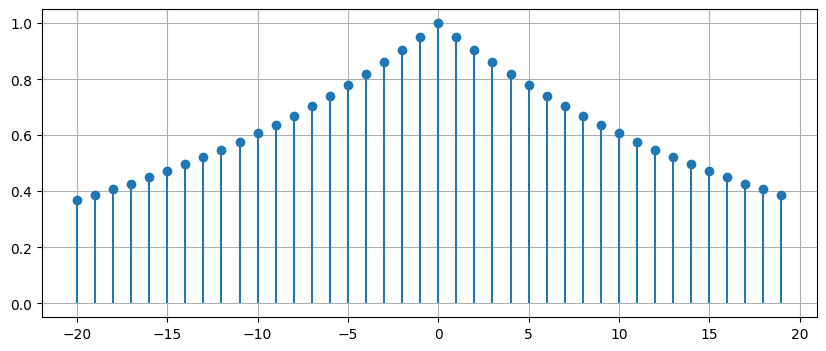

In [86]:
alpha = 0.05
N     = 20
w     = np.arange(-N, N)

plt.figure(figsize=(10, 4))
plt.stem(w, np.exp(-np.abs(w)*alpha), basefmt=' ')
plt.grid()

Quanto menor o OSNR, mais plano o filtro, pois mais símbolos são necessários para filtrar a contribuição do ruído aditivo. Por outro lado, quanto maior o ruído de fase, mais abruptas as bordas do filtro, pois as amostras de ruído de fase nas bordas do filtro são menos correlacionadas com o termo de ruído de fase central. A ideia é usar uma média móvel da M-ésima potência do sinal recebido para estimar a fase da portadora baseada em uma janela laplaciana para se obter uma estimativa próxima da máxima verossimilhança fazendo a escolha de um $\alpha$ de forma empírica ou optar por uma janela constante, e depois compensar essa fase no sinal recebido.

<br>
<center>
    <img src="https://i.postimg.cc/1RGjKt3t/Screenshot-from-2024-07-24-23-05-21.png">
</center>
</br>

In [110]:
def movingAverage(x, N, alpha=0.03, window='constant'):
    """
    Calcula a média móvel para um array 2D ao longo de cada coluna.

    Parameters
    ----------
    x : np.array
        Matriz 2D do tipo (M,N), onde M é a quantidade das amostras
        e N o número de colunas.

    N : int
        Comprimento da janela.

    alpha : float, optional
        Parâmetro de escala (dispersão da distribuição laplaciana), by default 0.03

    window : str, optional
        Define a janela da média móvel [constant, laplacian], by default 'constant'

    Returns
    -------
    np.array
        Matriz 2D contendo a média móvel ao longo de cada coluna.
    
    Raises
    ------
    ValueError
        Caso a janela não seja especificada de forma correta.
    
    ValueError
        Caso a janela tenha um comprimento maior que o sinal de entrada.
    """
    
    nModes = x.shape[1]
    
    if window == 'constant':
        h = np.ones(N) / N
    
    elif window == 'laplacian':
        w = np.arange(-N, N)
        h = np.exp(-np.abs(w)*alpha)
    
    elif window == 'DDlaplacian':
        w = np.arange(0, N)
        h = np.exp(-np.abs(w)*alpha)

    else:
        raise ValueError('Janela especificada incorretamente.')

    if len(h) > x.shape[0]:
        raise ValueError('A janela deve ser menor que o comprimento do sinal de entrada.')
    
    y = np.zeros(x.shape, dtype=x.dtype)

    for index in range(nModes):
        
        # calcula a média móvel 
        average = np.convolve(x[:, index], h, mode='same')
        
        # obtém a saída de mesmo comprimento da entrada
        y[:, index] = average
        
    return y

In [127]:
def viterbiCPR(sigRx, alpha=0.03, N=85, M=4):
    """
    Recupera a fase da portadora com o algoritmo Virterbi & Viterbi

    Parameters
    ----------
    sigRx : np.array
        Sinal de entrada para se obter a referência de fase.

    N : int, optional
        Comprimento do filtro, by default 85

    M : int, optional
        Ordem da potência, by default 4

    Returns
    -------
    tuple:
        sigRx (np.array): Constelação com referência de fase.
        phiTime (np.array): Estimativa de fase em cada modo.
    """

    phiTime = np.unwrap((np.angle(movingAverage(sigRx**M, N, alpha, window='laplacian')) / M) - np.pi/M, axis=0)
    phiTime = np.unwrap(4 * phiTime, axis=0) / 4

    sigRx = pnorm(sigRx * np.exp(-1j * phiTime))
    
    return sigRx, phiTime

## Decision-Directed Algorithm

Os estimadores direcionados à decisão usam decisões para eliminar a dependência das informações transmitidas. No caso da recuperação da fase direcionada à decisão (DD), N decisões de símbolos anteriores são usadas para estimar a realização do ruído de fase $\theta [k]$. A fase estimada $\hat{\theta} [k]$ então compensa a mudança de fase impressa no símbolo recebido $z[k]$.

Embora bastante simples, essa estrutura recursiva tem duas desvantagens principais. Primeiro, o algoritmo requer várias decisões anteriores para estimar a fase atual, o que pode ser um problema para o paralelismo de hardware. Segundo, o algoritmo é baseado em estimativas anteriores de ruído de fase (amostras atuais e futuras não são usadas), introduzindo um erro de previsão que não está presente em soluções de feedforward.

$\hat{\theta}_{ML} [k]$ pode ser dado por:

$$\hat{\theta}_{\mathrm{ML}}[k]=a r g\left(\sum_{i=1}^{N}w_{\mathrm{ML},i}z[k-i]\hat{s}^{*}[k-i]\right)$$

In [128]:
def DDcpr(sigRx, constSymb, N=85):
    """
    Recupera a fase da portadora com o algoritmo direcionado por decisão.

    Parameters
    ----------
    sigRx : np.array
        Sinal de entrada para se obter a referência de fase.
        
    constSymb : np.array
        Decisão dos símbolos transmitidos

    N : int, optional
        Comprimento do filtro, by default 85

    Returns
    -------
    tuple:
        sigRx (np.array): Constelação com referência de fase.
        phiTime (np.array): Estimativa de fase em cada modo.
    """

    phiTime = np.angle(movingAverage(sigRx * pnorm(np.conj(constSymb)), N, window='DDlaplacian'))
    # remove as descontinuidades de fase
    phiTime = np.unwrap(4 * phiTime) / 4
    
    sigRx = pnorm(sigRx * np.exp(-1j * phiTime))

    return sigRx, phiTime

## Teste algoritmos de recuperação de portadora para receptores coerentes

Esta simulação conta com um front-end com deficiências de deslocamento de frequência e ruído de fase, com a finalidade de avaliar os algoritmos implementados para realizar a recuperação de portadora.  

In [129]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                  # order of the modulation format
paramTx.constType = 'qam'       # modulation scheme
paramTx.Rs  = 32e9              # symbol rate [baud]
paramTx.SpS = 16                # samples per symbol
paramTx.pulse = 'rrc'           # pulse shaping filter
paramTx.Ntaps = 4096            # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01         # RRC rolloff
paramTx.Pch_dBm = -2            # power per WDM channel [dBm]
paramTx.Nch     = 1             # number of WDM channels
paramTx.Fc      = 193.1e12      # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3         # laser linewidth in Hz
paramTx.freqSpac = 37.5e9       # WDM grid spacing
paramTx.Nmodes = 2              # number of signal modes [2 for polarization multiplexed signals]
paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

## fiber parameters:
paramFiber = parameters()
paramFiber.L = 100          # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fs          # Frequência de amostragem do sinal [amostras/segundo]

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

# sigCh = linearFiberChannel(sigWDM_Tx, paramFiber)
SNRdB = 30
sigCh = awgn(sigWDM_Tx, SNRdB, Fs, paramTx.Rs)

  0%|          | 0/1 [00:00<?, ?it/s]

## Front-end sujeito a deslocamento de frequência e ruído de fase

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 60.00 MHz



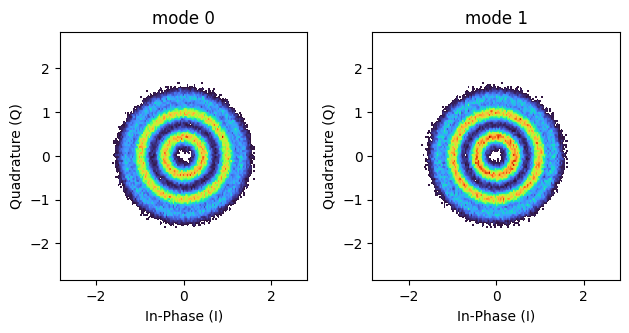

In [130]:
# Receiver

# parameters
chIndex  = 0    # index of the channel to be demodulated

freqGrid = paramTx.freqGrid
π  = np.pi
t  = np.arange(0, len(sigCh))*1/Fs 

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (paramTx.Fc + freqGrid[chIndex])/1e12, const.c/(paramTx.Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 60e6                  # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

# generate CW laser LO field
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigCh)
paramLO.Fs = Fs

sigLO = basicLaserModel(paramLO)
sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig = 0)

# plot constellation
pconst(sigRx[0::paramTx.SpS,:],R=2);

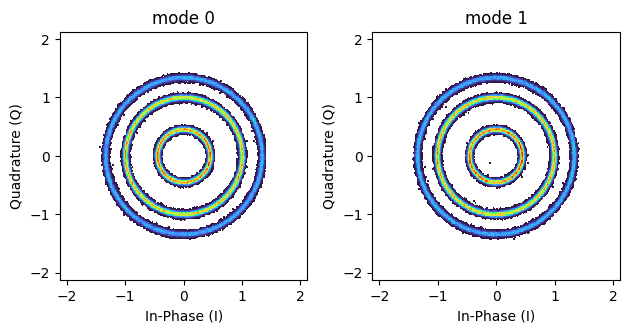

In [131]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pnorm(pulse)           
sigRx = firFilter(pulse, sigRx)

# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx, paramDec)

pconst(sigRx, R=1.5);

## Recuperação de frequência da portadora com o método de 4th potência

Compensa o deslocamento de frequência considerando um laser ideal sem ruído de fase.

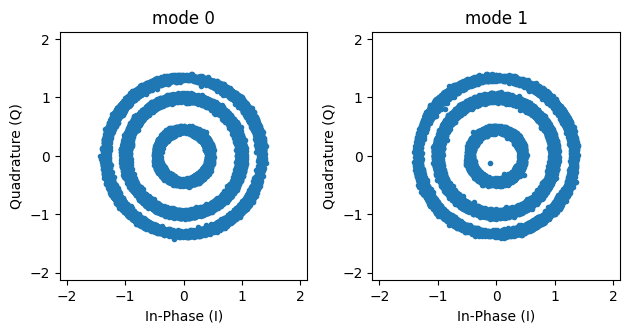

      pol.X      pol.Y      
 SER: 8.64e-01,  8.64e-01
 BER: 3.72e-01,  3.72e-01
 SNR: -0.83 dB,  -0.84 dB


In [132]:
# compensa o deslocamento de frequência
sigRxFOE, indFO = fourthPower(sigRx, Fs)

# obtém a nova constelação com desvio de frequência compensado
pconst(sigRxFOE, R=1.5, pType='fast')

# Performance metrics
discard = 1000
d = pnorm(symbTx)

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(sigRxFOE[ind,:], d[ind,:], paramTx.M, paramTx.constType)

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))

## Plot PSD

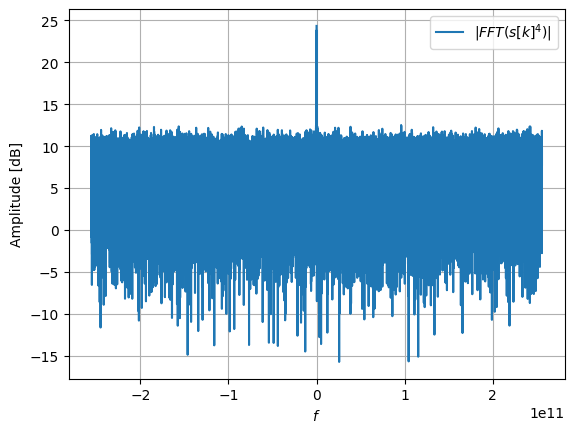

In [133]:
plt.plot(Fs * np.fft.fftfreq(sigRx.shape[0]), 10*np.log10(np.abs(np.fft.fft(sigRx[:, 0]**4))), label=r"$|FFT(s[k]^4)|$")
plt.ylabel('Amplitude [dB]')
plt.xlabel(r'$f$')
plt.legend()
plt.grid()

## Recuperação de fase com Viterbi & Viterbi

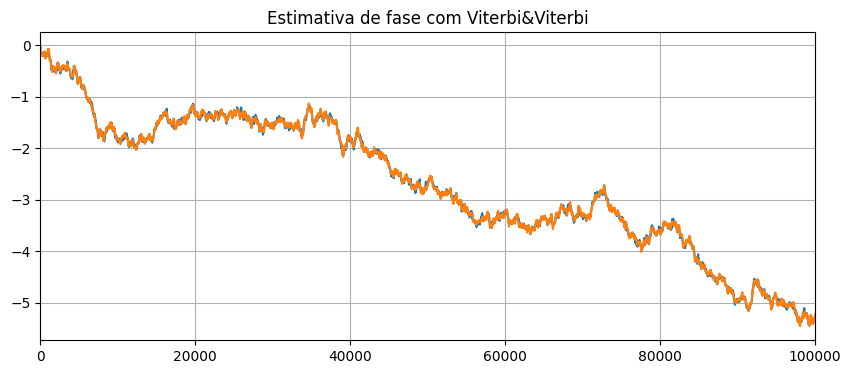

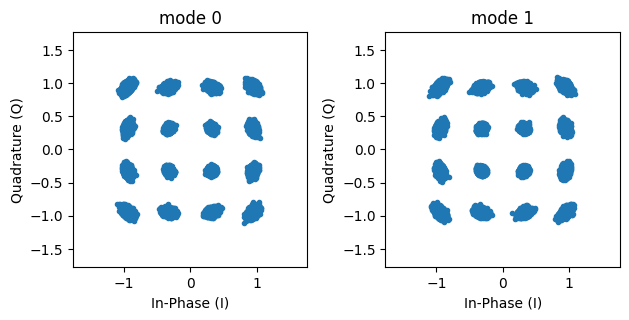

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 26.96 dB,  26.87 dB


In [134]:
# recupera a fase da portadora utilizando o algoritmo de viterbi&viterbi
sigRxCPR, phi = viterbiCPR(pnorm(sigRxFOE), N=91)

plt.figure(figsize=(10, 4))
plt.title('Estimativa de fase com Viterbi&Viterbi')
plt.plot(phi, '-')
plt.xlim(0, len(phi))
plt.grid();

discard = 20000

# obtem a nova constelação com referência de fase
pconst(sigRxCPR[discard:], pType='fast')

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(sigRxCPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))

## Recuperação de fase com Decision-Directed Algorithm

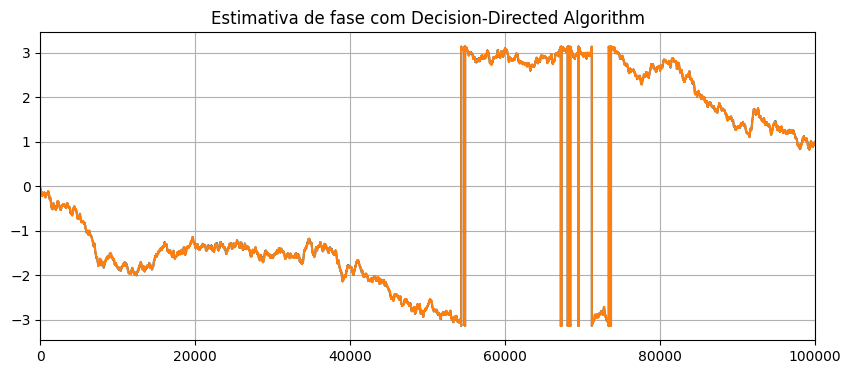

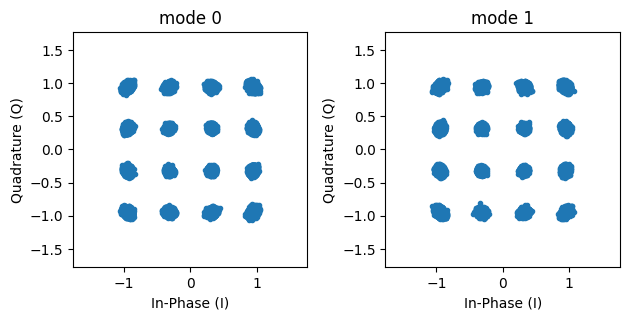

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 28.09 dB,  28.08 dB


In [135]:
sigRxCPR, phi = DDcpr(pnorm(sigRxFOE), symbTx, N=81)

plt.figure(figsize=(10, 4))
plt.title('Estimativa de fase com Decision-Directed Algorithm')
plt.plot(phi, '-')
plt.xlim(0, len(phi))
plt.grid();

discard = 20000

# obtem a nova constelação com referência de fase
pconst(sigRxCPR[discard:], pType='fast')

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(sigRxCPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))